In [4]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
j=3
k=1
ecross = 1 - ((j-k)/j)**(2/3)    
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=1e-5, P=1, e=0., l=0)
sim.add(e=0.1, P=j/(j-k), l=np.pi)
sim.move_to_com()
sim.integrator="whfast"
sim.dt = 0.03
ps = sim.particles

<IPython.core.display.Javascript object>


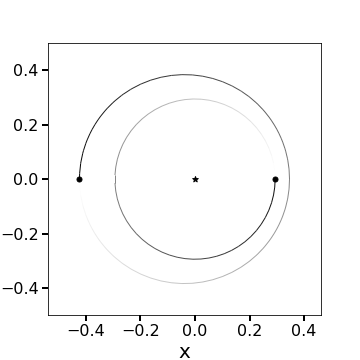

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9718c3a810>)

In [8]:
rebound.OrbitPlot(sim)

In [9]:
%matplotlib notebook

class Clicker(object):
    def __init__(self,j,k,m,etilde):
        fig, self.ax = plt.subplots(figsize=(12,8))
        self.j = j
        self.k = k
        self.m = m
        
        ecross = 1 - ((j-k)/j)**(2/3)
        self.e = etilde*ecross
        self.cid = self.ax.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        phi = event.xdata
        P = event.ydata
        
        # phi = j*l2 - (j-k)*l1 - k*pomega1
        # if pomega1 = 0, l1=0, l2 = phi/j
        sim = rebound.Simulation()
        sim.add(m=1)
        sim.add(m=self.m, P=1)
        sim.add(e=self.e, P=P, l=phi/self.j)
        sim.move_to_com()
        sim.integrator="whfast"
        sim.dt = 0.03
        ps = sim.particles

        Nout = 1000
        P, phi = np.zeros(Nout), np.zeros(Nout)
        times = np.linspace(0, 300, Nout)
        
        for i, time in enumerate(times):
            sim.integrate(time)
            P[i] = ps[2].P/ps[1].P
            phi[i] = np.mod(self.j*ps[2].l-(self.j-self.k)*ps[1].l-self.k*ps[2].pomega, 2*np.pi)
        
        self.ax.plot(phi, P, 'k.')

<IPython.core.display.Javascript object>


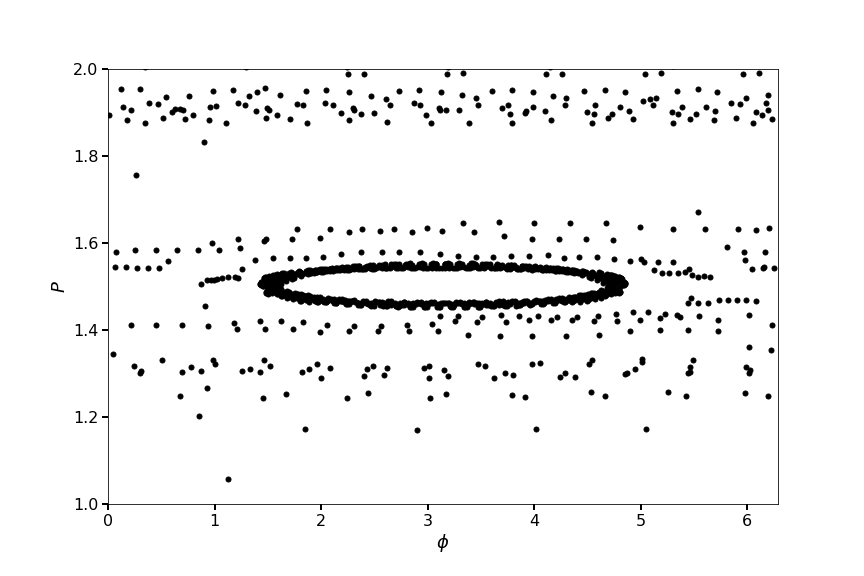

Text(0, 0.5, '$P$')

In [10]:
clicker=Clicker(j=3, k=1, m=1e-3, etilde=0.8) 

clicker.ax.set_xlim(0,2*np.pi)
clicker.ax.set_ylim(1, 2)
clicker.ax.set_xlabel('$\phi$',fontsize=18)
clicker.ax.set_ylabel('$P$',fontsize=18)

In [11]:
%matplotlib notebook

class Clicker(object):
    def __init__(self,j,k,m,etilde, Npts=300):
        fig, self.ax = plt.subplots(figsize=(12,8))
        self.j = j
        self.k = k
        self.m = m
        self.etilde = etilde
        self.Npts = Npts
        self.cid = self.ax.figure.canvas.mpl_connect('button_press_event', self)
        
        if k > 5:
            raise("Only supports resonances of order k=5 or less")
        h = [0, 0.535, 0.426, 0.420, 0.454, 0.519] # coefficients for k order resonances
        self.ax.set_xlim([0,2*np.pi])
        #fracPwidth = 2*np.sqrt(3*h[k])*m**(1/2)*etilde**(k/2)
        #self.ax.set_ylim([j/(j-k)-10*Pwidth, j/(j-k)+10*Pwidth])
        self.ax.set_xlabel('$\phi$',fontsize=18)
        self.ax.set_ylabel('$P$',fontsize=18)
        
    def __call__(self, event):
        phi = event.xdata
        P = event.ydata
        
        sim = self.make_sim(phi, P, self.m, self.etilde, self.j, self.k)
        philist, Plist, collision = self.run(sim, self.j, self.k)
        if collision == True:
            if phi:
                self.ax.plot(philist, Plist, 'r.')
            else:
                self.ax.plot([phi], [P], 'r.') # plot initial point in case collision happens before first crossing
        else:
            self.ax.plot(philist, Plist, 'k.')
    
    def make_sim(self, phi, P, m, etilde, j, k):
        ecross = 1 - ((j-k)/j)**(2/3)
        e = self.etilde*ecross
        
        # start l1 at pi 
        # phi = j*l2 - (j-k)*l1 - k*pomega1
        # if pomega1 = 0, l1=pi, l2 = (phi+(j-k)*pi)/j
        sim = rebound.Simulation()
        sim.add(m=1)
        sim.add(m=m, P=1, l=(phi-j*np.pi)/k)
        sim.add(e=e, P=P, l=sim.particles[1].l + np.pi)
        sim.move_to_com()
        sim.particles[1].r = sim.particles[1].a*(sim.particles[1].m/3/sim.particles[0].m)**(1/3)
        sim.collision = "line"
        return sim

    def hyper(self, sim): # section when l1 overtakes l2. When l1 < l2, sin(l2-l1) > 0, when it overtakes, sin(l2-l1)<0
        return np.sin(sim.particles[2].l-sim.particles[1].l) 

    def run(self, sim, j, k):
        N_points_max = self.Npts # maximum number of point in our Poincare Section
        N_points = 0
        poincare_map = np.zeros((N_points_max,2))
        ps = sim.particles
        
        # Integrate simulation in small intervals
        # After each interval check if we crossed the 
        # hypersurface. If so, bisect until we hit the 
        # hypersurface exactly up to a precision
        # of dt_epsilon
        dt = 0.1
        dt_epsilon = 1e-2*dt
        sign = self.hyper(sim)
        phi, P = [], []
        collision=False
        while sim.t<1e4 and N_points < N_points_max:
            oldt = sim.t
            olddt = sim.dt
            try:
                sim.integrate(oldt+dt)
            except rebound.Collision:
                collision=True
                return phi, P, collision
            nsign = self.hyper(sim)
            if sign > 0 and nsign < 0.: # see condition in hyper
                # Hyper surface crossed.
                leftt = oldt
                rightt = sim.t
                sim.dt = -olddt
                while (rightt-leftt > dt_epsilon):
                    # Bisection.
                    midt = (leftt+rightt)/2.
                    try:
                        sim.integrate(midt)
                    except:
                        collision=True
                        return phi, P, collision
                    
                    msign = self.hyper(sim)
                    if msign*sign > 0.:
                        leftt = midt
                        sim.dt = 0.3*olddt
                    else:
                        rightt = midt
                        sim.dt = -0.3*olddt
                # Hyper surface found up to precision of dt_epsilon. Store phi and P
                # Don't need to check crossing direction, since l1 always overtakes l2. But need to check (l2-l1) != pi
                if np.cos(ps[2].l-ps[1].l) > 0: 
                    tp = np.pi*2.
                    phi.append(np.mod(j*ps[2].l-(j-k)*ps[1].l-k*ps[2].pomega, 2*np.pi))
                    P.append(ps[2].P/ps[1].P) # Store value for map
                    N_points += 1
                sim.dt = olddt
                try:
                    sim.integrate(oldt+dt)
                except:
                    collision=True
                    return phi, P, collision
            sign = nsign
        return phi, P, collision

# Debug k=2 case, might clear up k=1 overlaps

<IPython.core.display.Javascript object>


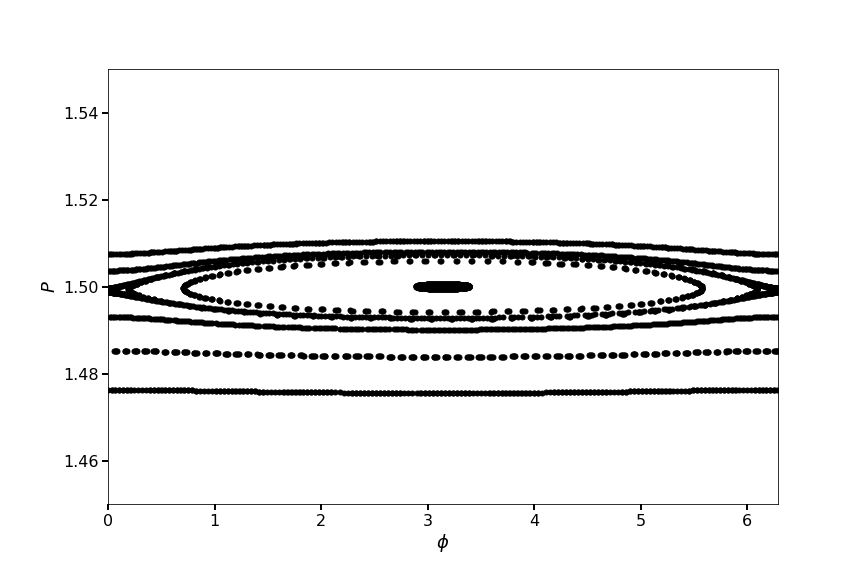

(0, 6.283185307179586)

In [12]:
%matplotlib notebook

clicker=Clicker(j=3, k=1, m=1e-5, etilde=0.3) 
clicker.ax.set_ylim([1.45, 1.55])
clicker.ax.set_xlim([0, 2*np.pi])

In [5]:
%matplotlib notebook
plt.style.use('paper')
def relativelyprime(num1, num2):
    mn = min(num1, num2) 
    for i in range(1, mn+1): 
         if num1%i==0 and num2%i==0: 
             hcf = i 
    if hcf == 1: 
         return True
    else: 
         return False
        
class Clicker(object):
    def __init__(self,j,k,m, kmax=1):
        fig, self.ax = plt.subplots(figsize=(12,8))
        self.j = j
        self.k = k
        self.m = m
        self.cid = self.ax.figure.canvas.mpl_connect('button_press_event', self)
        
        if k > 5:
            raise("Only supports resonances of order k=5 or less")
        h = [0, 0.535, 0.426, 0.420, 0.454, 0.519, 0.613, 0.742, 0.914, 1.143, 1.445] # coefficients for k order resonances
        self.ax.set_xlim([0,1])
        self.ax.set_ylim([1, 2])
        self.ax.set_xlabel('Normalized Eccentricity',fontsize=18)
        self.ax.set_ylabel('Test Particle Period (yrs)',fontsize=18)
        

        jmax=200

        for k in range(1,kmax+1):
            for j in range(1+k, jmax):
                if not relativelyprime(j, k):
                    continue
                P21 = j/(j-k) # P2/P1
                if P21 > self.ax.get_ylim()[0] and P21 < self.ax.get_ylim()[1]:
                    es = np.linspace(0, 1, 100)
                    dPs = P21*2*np.sqrt(3)*h[k]**(1/2)*m**(1/2)*(es)**(k/2)
                    self.ax.plot(es, P21+dPs, 'k', alpha=0.5)
                    self.ax.plot(es, P21-dPs, 'k', alpha=0.5)
                    self.ax.fill_between(es, P21-dPs, P21+dPs, alpha=0.2, color='k')
            
        #deltas = (1-P12s**(2/3))/(2*mu/3)**(1/4)
        #ax.plot(1/P12s, np.exp(-2.2*deltas**(-4/3)), color='purple', lw=5, label='2-planet Criterion')
        
    def __call__(self, event):
        etilde = event.xdata
        P = event.ydata
        phi = np.pi # at the stable eq
        
        sim = self.make_sim(phi, P, self.m, etilde, self.j, self.k)
        Plist, collision = self.run(sim)
        if collision == True:
            self.ax.plot([etilde]*len(Plist), Plist, 'r.')
        else:
            self.ax.plot([etilde]*len(Plist), Plist, 'k.')
    
    def make_sim(self, phi, P, m, etilde, j, k):
        ecross = 1 - ((j-k)/j)**(2/3)
        e = etilde*ecross
        
        # start l1 at pi 
        # phi = j*l2 - (j-k)*l1 - k*pomega1
        # if pomega1 = 0, l1=pi, l2 = (phi+(j-k)*pi)/j
        sim = rebound.Simulation()
        sim.add(m=1)
        sim.add(m=m, P=1, l=(phi-j*np.pi)/k)
        sim.add(e=e, P=P, l=sim.particles[1].l + np.pi)
        sim.move_to_com()
        sim.particles[1].r = sim.particles[1].a*(sim.particles[1].m/3/sim.particles[0].m)**(1/3)
        sim.collision = "line"
        return sim

    def run(self, sim):
        Npts = 50
        ps = sim.particles
        Plist = []
        collision = False
        times = np.linspace(0, 1000*np.sqrt(2), Npts)
        for time in times:
            try:
                sim.integrate(time)
            except rebound.Collision:
                collision = True
                return Plist, collision
            Plist.append(ps[2].P/ps[1].P)
            
        return Plist, collision

<IPython.core.display.Javascript object>


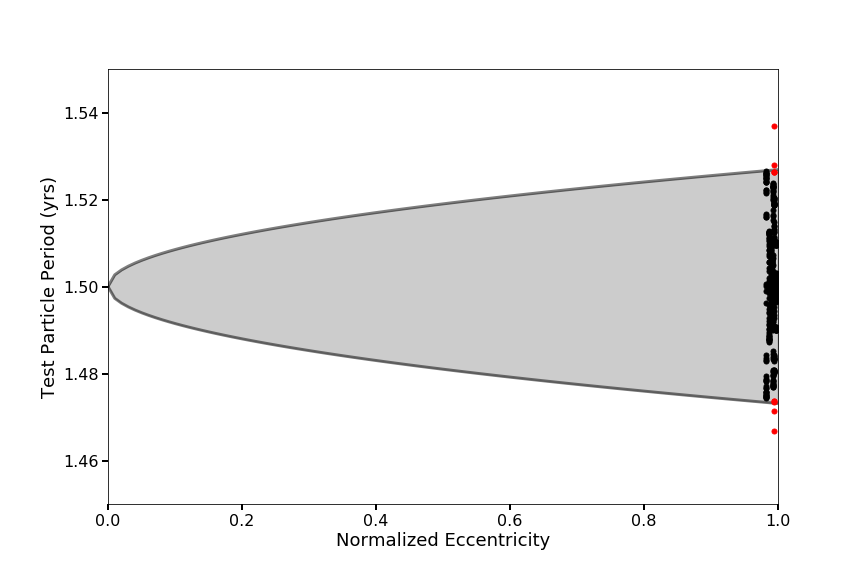

(1.45, 1.55)

In [6]:
%matplotlib notebook

clicker=Clicker(j=3, k=1, m=5e-5, kmax=1) 
clicker.ax.set_ylim([1.45, 1.55])

<IPython.core.display.Javascript object>


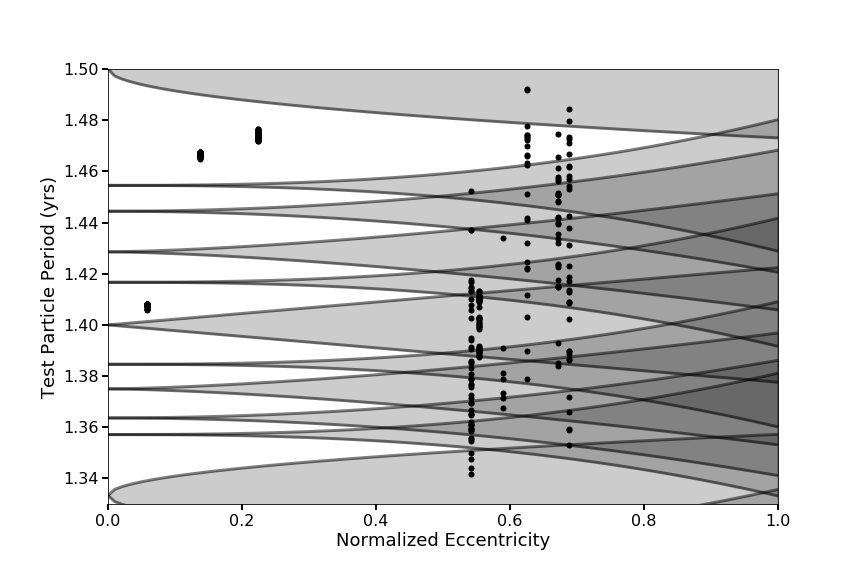

(1.33, 1.5)

In [6]:
%matplotlib notebook

clicker=Clicker(j=3, k=1, m=5e-5, kmax=5) 
clicker.ax.set_ylim([1.33, 1.5])

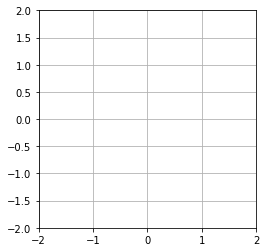

In [5]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

class DoublePendulum:
    """Double Pendulum Class

    init_state is [theta1, omega1, theta2, omega2] in degrees,
    where theta1, omega1 is the angular position and velocity of the first
    pendulum arm, and theta2, omega2 is that of the second pendulum arm
    """
    def __init__(self,
                 init_state = [120, 0, -20, 0],
                 L1=1.0,  # length of pendulum 1 in m
                 L2=1.0,  # length of pendulum 2 in m
                 M1=1.0,  # mass of pendulum 1 in kg
                 M2=1.0,  # mass of pendulum 2 in kg
                 G=9.8,  # acceleration due to gravity, in m/s^2
                 origin=(0, 0)): 
        self.init_state = np.asarray(init_state, dtype='float')
        self.params = (L1, L2, M1, M2, G)
        self.origin = origin
        self.time_elapsed = 0

        self.state = self.init_state * np.pi / 180.
    
    def position(self):
        """compute the current x,y positions of the pendulum arms"""
        (L1, L2, M1, M2, G) = self.params

        x = np.cumsum([self.origin[0],
                       L1 * sin(self.state[0]),
                       L2 * sin(self.state[2])])
        y = np.cumsum([self.origin[1],
                       -L1 * cos(self.state[0]),
                       -L2 * cos(self.state[2])])
        return (x, y)

    def energy(self):
        """compute the energy of the current state"""
        (L1, L2, M1, M2, G) = self.params

        x = np.cumsum([L1 * sin(self.state[0]),
                       L2 * sin(self.state[2])])
        y = np.cumsum([-L1 * cos(self.state[0]),
                       -L2 * cos(self.state[2])])
        vx = np.cumsum([L1 * self.state[1] * cos(self.state[0]),
                        L2 * self.state[3] * cos(self.state[2])])
        vy = np.cumsum([L1 * self.state[1] * sin(self.state[0]),
                        L2 * self.state[3] * sin(self.state[2])])

        U = G * (M1 * y[0] + M2 * y[1])
        K = 0.5 * (M1 * np.dot(vx, vx) + M2 * np.dot(vy, vy))

        return U + K

    def dstate_dt(self, state, t):
        """compute the derivative of the given state"""
        (M1, M2, L1, L2, G) = self.params

        dydx = np.zeros_like(state)
        dydx[0] = state[1]
        dydx[2] = state[3]

        cos_delta = cos(state[2] - state[0])
        sin_delta = sin(state[2] - state[0])

        den1 = (M1 + M2) * L1 - M2 * L1 * cos_delta * cos_delta
        dydx[1] = (M2 * L1 * state[1] * state[1] * sin_delta * cos_delta
                   + M2 * G * sin(state[2]) * cos_delta
                   + M2 * L2 * state[3] * state[3] * sin_delta
                   - (M1 + M2) * G * sin(state[0])) / den1

        den2 = (L2 / L1) * den1
        dydx[3] = (-M2 * L2 * state[3] * state[3] * sin_delta * cos_delta
                   + (M1 + M2) * G * sin(state[0]) * cos_delta
                   - (M1 + M2) * L1 * state[1] * state[1] * sin_delta
                   - (M1 + M2) * G * sin(state[2])) / den2
        
        return dydx

    def step(self, dt):
        """execute one time step of length dt and update state"""
        self.state = integrate.odeint(self.dstate_dt, self.state, [0, dt])[1]
        self.time_elapsed += dt

#------------------------------------------------------------
# set up initial state and global variables
pendulum = DoublePendulum([180., 0.0, -20., 0.0])
dt = 1./30 # 30 fps

#------------------------------------------------------------
# set up figure and animation
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-2, 2), ylim=(-2, 2))
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
energy_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)

def init():
    """initialize animation"""
    line.set_data([], [])
    time_text.set_text('')
    energy_text.set_text('')
    return line, time_text, energy_text

def animate(i):
    """perform animation step"""
    global pendulum, dt
    pendulum.step(dt)
    
    line.set_data(*pendulum.position())
    time_text.set_text('time = {0:.1f}'.format(pendulum.time_elapsed))
    energy_text.set_text('energy = {0:.3f} J'.format(pendulum.energy()))
    return line, time_text, energy_text

# choose the interval based on dt and the time to animate one step
from time import time
t0 = time()
animate(0)
t1 = time()
interval = 1000 * dt - (t1 - t0)

ani = animation.FuncAnimation(fig, animate, frames=300,
                              interval=interval, blit=True, init_func=init)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
#ani.save('double_pendulum.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()